<img src=tutorial_images\NINC_DBC_DMCBH_logos.jpg>

These tutorial notebooks were developed at the Djavad Mowafaghian Centre for Brain Health by the NINC/UBC Brain Circuits team.  If you find the tutorials useful you can acknowledge us with the following statement: 

<em>"This work was supported by resources made available through the Dynamic Brain Circuits cluster and the NeuroImaging and NeuroComputation Core at the UBC Djavad Mowafaghian Centre for Brain Health (RRID:SCR_019086)."</em>

If you use the packages in your research, please cite the originators as per their documentation.

# Suite2p Tutorial - part 2

<b>This jupyter notebook is a continuation of the other notebook titled 's2p-tutorial_part-1.ipynb'.</b> If you have not already, please complete the steps outlined in that notebook before proceeding with part 2. 

In 's2p-tutorial_part-1.ipynb', we learned how to send run the suite2p program with sample .tiff files. In the second part of the Suite2p demo, we will download some sample data that came from a previously run Suite2p process, and see how suite2p's data can be analyzed through various methods demonstrated below.

If the code block below is showing warnings, check that you have the correct kernel running.
>To view your current kernel or change kernels, go to the top menu bar and click Kernel > Change kernel. In the dropdown menu, you should be selecting ```Python[conda env:suite2p]```.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import h5py
import os
from pathlib import Path

# For the model training
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score


from tqdm import tqdm
from sklearn.model_selection import GridSearchCV, cross_val_score

Go to <a href="https://osf.io/ztcnm/?view_only=59d6948657a742f688b4cac9ad1f54e9">this OSF page</a> and download ".zip". In your file explorer, locate the download and unzip, then move the folder (which should be named 'M210914_DYN_20114_FB') into
<br><br> 
's2p_demo' > 'my_files' > 'test_analysis'
<br><br>
on your local computer. 

The next code block points variables to the folder locations of your downloaded sample data.

In [9]:
experiment = "M210914_DYN_20114_FB"
experiment_folder = Path(Path.cwd(), "my_files", "test_analysis", experiment)

We will now define some methods to be used throughout this demo.

In [50]:
def load_h5_file_orientation_experiment(experiment_folder, experiment, load_spatial_footprints=False, use_calcium=True): # loads the h5 file that came out of the suite2p run
    with h5py.File(os.path.join(experiment_folder, experiment+"_aligned_dataset.h5"), 'r') as f:
        cell_spikes = np.asarray(f['cell_spikes'])
        cell_traces = np.asarray(f['processed_cell_traces'])
        df_cell_traces = np.asarray(f['df_cell_traces'])
        is_cell = np.asarray(f['is_cell'])
        if load_spatial_footprints:
            spatial_footprints = np.asarray(f['spatial_footprints'])
        #wheel_data = np.asarray(f['wheel_data'])
        time_axis = np.asarray(f['time_axis'])
        sampling_rate = np.round(np.asarray(f['sampling_rate']),1)
        #filter_band = np.asarray(f['filter_band'])
        brain_area = np.asarray(f['brain_area']).astype(str)
        mouse_id   = np.asarray(f['mouse_id']).astype(str)
        
    align_df = pd.read_hdf(os.path.join(experiment_folder, "Alignment_Indeces", experiment+"_alignment_indeces_data_frame.h5"))
    n_trials = align_df['trial_stim_orientations'].count()
    
    # filter segmented cells that were actually labeled as cells
    df_cell_traces = df_cell_traces[np.where(is_cell[:, 0])]
    cell_traces = cell_traces[np.where(is_cell[:, 0])]
    cell_spikes = cell_spikes[np.where(is_cell[:, 0])]
    
    if load_spatial_footprints:
        spatial_footprints = spatial_footprints[np.where(is_cell[:, 0])]

    n_cells = df_cell_traces.shape[0]
    
    # remove the blank which will be last after sorting
    all_orientations = list(align_df['trial_stim_orientations'].unique())
    all_orientations = np.sort(all_orientations)[:-1]
    
    all_sfs = list(align_df['trial_stim_sfs'].unique())
    all_sfs = np.sort(all_sfs)[:-1]

    n_orientations = len(all_orientations)
    n_sfs = len(all_sfs)
    n_repeats = ((align_df['trial_stim_orientations'] == all_orientations[0]) & 
                 (align_df['trial_stim_sfs'] == all_sfs[0])).sum()
    n_repeats2 = ((align_df['trial_stim_orientations'] == all_orientations[1]) & 
                 (align_df['trial_stim_sfs'] == all_sfs[1])).sum()
    
    assert n_repeats == n_repeats2 # sanity check
    
    # In seconds
    pre = -0.5
    post = 1.5

    pre = int(sampling_rate*pre)
    post = int(sampling_rate*post)

    x_axis = np.linspace(pre/sampling_rate, post/sampling_rate, post-pre)
    # Here we force the closest point pre zero to be the zero
    x_axis -= x_axis[x_axis <= 0].max()
    
    trial_responses = np.zeros((n_orientations, n_sfs, n_repeats, n_cells, post-pre), dtype=np.float32)
    for o, ori in enumerate(all_orientations):
        for s, sf in enumerate(all_sfs):
            subset_stim_indices = align_df['twoP_stim_onset'][np.where((align_df['trial_stim_orientations'] == ori) &
                                                                       (align_df['trial_stim_sfs'] == sf))[0]]

            if use_calcium:
                resp, resp_axis = calcium_baseline_subtract(pre, post, sampling_rate, subset_stim_indices, df_cell_traces) 

            else:
                resp, resp_axis = calculate_responses_per_index(pre, post, sampling_rate, subset_stim_indices, cell_spikes)
                
            trial_responses[o, s, :, :, :] = resp
            
            
    n_blanks = (align_df['trial_stim_orientations']=='blank').sum()
    blank_responses = np.zeros((n_blanks, n_cells, post-pre))
            
    subset_stim_indices = align_df['twoP_stim_onset'][np.where((align_df['trial_stim_orientations'] == 'blank'))[0]]

    if use_calcium:
        resp, resp_axis = calcium_baseline_subtract(pre, post, sampling_rate, subset_stim_indices, df_cell_traces)             
    else:
        raise Exception("not implemented for this demo notebook")

    blank_responses[:, :, :] = resp
    
    exp_dict = {}
    exp_dict['mouse_id'] = mouse_id
    exp_dict['brain_area'] = brain_area
    exp_dict['all_orientations'] = all_orientations
    exp_dict['all_sfs'] = all_sfs
    exp_dict['n_repeats'] = n_repeats
    exp_dict['n_orientations'] = n_orientations
    exp_dict['n_sfs'] = n_sfs
    exp_dict['n_cells'] = n_cells
    exp_dict['align_df'] = align_df

    if load_spatial_footprints:
        exp_dict['spatial_footprints'] = spatial_footprints
    
    
    exp_dict['t1'] = -0.5
    exp_dict['t2'] = 1.0
    exp_dict['x_axis'] = x_axis
    exp_dict['trial_responses'] = trial_responses # responses to gratings
    exp_dict['blank_responses'] = blank_responses # responses to blank trials


    return exp_dict

def calcium_baseline_subtract(pre, post, sampling_rate, subset_stim_indices, traces):
    time_axis = np.linspace(pre/sampling_rate, post/sampling_rate, post-pre)
    stim_responses = np.zeros((subset_stim_indices.shape[0], traces.shape[0], post-pre), dtype=np.float32)
    for i, index in enumerate(subset_stim_indices):
        start = index+pre
        stop = index+post
        
        baseline = np.mean(traces[:, index+pre:index], axis=1)[:, np.newaxis]
        df = traces[:, start:stop] - baseline
        
        stim_responses[i] = df
        
    return stim_responses, time_axis

def calculate_responsive_cells_d_prime(X, blank_responses, x_axis, exp_dict):
    pre_stim_index = np.where(np.abs(x_axis-(-.2))< 0.1)[0][0]

    # due to slower time course on calcium, peak activity occurs later in the trial
    time_zero_index = np.where(np.abs(x_axis-(0))< 0.05)[0][0]

    peri_stim_index_1 = np.argsort(np.abs(x_axis-0.17))[0]
    peri_stim_index_2 = np.argsort(np.abs(x_axis-0.4))[0]
        
    
    pre_stim_mean =  X[:, :, :, :, pre_stim_index:time_zero_index].mean(axis=-1)

    #for calcium
    peri_stim_mean = X[:, :, :, :, peri_stim_index_1:peri_stim_index_2].mean(axis=-1).mean(axis=2)
    peri_stim_std  = X[:, :, :, :, peri_stim_index_1:peri_stim_index_2].mean(axis=-1).std(axis=2)
    blank_stim_mean = blank_responses[:, :, peri_stim_index_1:peri_stim_index_2].mean(axis=-1).mean(axis=0)
    blank_stim_std = blank_responses[:, :, peri_stim_index_1:peri_stim_index_2].mean(axis=-1).std(axis=0)

    # As per Marshel et al., 2011, and Juavinett & Callaway 2015
    responsive_cells = (peri_stim_mean.max(axis=0).max(axis=0)>0.06)
    
    
    stim_blank_d_prime = ((peri_stim_mean-blank_stim_mean[np.newaxis, np.newaxis, :])/
                        (peri_stim_std+blank_stim_std[np.newaxis, np.newaxis, :]))
    
    # As per the papers above, choose any cell with d'>1
    reliable_cells = (stim_blank_d_prime.max(axis=0).max(axis=0) > 1)    
    
    n_stimulus_responsive_cells = (responsive_cells & reliable_cells).sum()
    
    stimulus_responsive_cells = np.where((responsive_cells & reliable_cells))[0]
    
    return stimulus_responsive_cells, n_stimulus_responsive_cells

Using the methods we defined above, we now load the h5 data and store it in a dictionary. We then assign specific data to several variables for easier manipulation later.

In [39]:
use_calcium = True
exp_dict = load_h5_file_orientation_experiment(experiment_folder, experiment, load_spatial_footprints=False, use_calcium=use_calcium) # load data into dictionary

mouse_id = exp_dict['mouse_id']
brain_area = exp_dict['brain_area']
all_orientations = exp_dict['all_orientations']
all_sfs = exp_dict['all_sfs'] # sfs = spacial frequencies
n_repeats = exp_dict['n_repeats']
n_orientations = exp_dict['n_orientations']
n_sfs = exp_dict['n_sfs']
n_cells = exp_dict['n_cells']

t1 = exp_dict['t1']
t2 = exp_dict['t2']
x_axis = exp_dict['x_axis']
X = exp_dict['trial_responses']
blank_responses = exp_dict['blank_responses']


stimulus_responding_cells, n_stimulus_responding_cells = calculate_responsive_cells_d_prime(X, blank_responses, x_axis, exp_dict)
proportion_stim_responding_cells = n_stimulus_responding_cells/n_cells

In [40]:
stimulus_responding_cells, n_stimulus_responding_cells = calculate_responsive_cells_d_prime(X, blank_responses, x_axis, exp_dict)
proportion_stim_responding_cells = n_stimulus_responding_cells/n_cells

X = X[:, :, :, stimulus_responding_cells, :]

We can test that our variable assignments are as we'd expect by checking the outputs from the code blocks below:

In [41]:
all_sfs # should output all possible spacial frequencies that were shown to mouse

array(['0.02', '0.04', '0.1', '0.2', '0.5'], dtype='<U5')

In [42]:
all_orientations # should output all possible orientations that were shown to mouse

array(['0', '135', '45', '90'], dtype='<U5')

In [43]:
# (orientations, spatial_frequencies, repeats, cells, timepoints)
X.shape # should output total number of possibilities for each variable type (eg total number of possible orientations, total number of spatial frequencies, etc)

(4, 5, 15, 218, 60)

## Multinomial logistic regression

In [44]:
Y_or = np.zeros_like(X[:, :, :, 0, 0], dtype=object)
Y_sf = np.zeros_like(X[:, :, :, 0, 0], dtype=object)

In [45]:
# Build the ground truths of the visual stimuli
for o in range(X.shape[0]):
    for s in range(X.shape[1]):
        for r in range(X.shape[2]):
            Y_or[o, s, r] = str(all_orientations[o])
            Y_sf[o, s, r] = str(all_sfs[s])

In [46]:
# Assuming X, Y_or, and Y_sf are already defined and loaded

# Flatten the tensors
nsamples, nfeatures = X.shape[0] * X.shape[1] * X.shape[2], X.shape[3]
X_flat = X.reshape(nsamples, nfeatures, X.shape[-1])  # Reshape for each timepoint

# Flatten labels
Y_or_flat = Y_or.flatten()
Y_sf_flat = Y_sf.flatten()

# Prepare DataFrame for results
results = []

# Iterate over each timepoint
for t in tqdm(range(X.shape[-1])):
    X_t = X_flat[:, :, t]  # Select data at timepoint t
    # Value of C was found after doing hyperparameter search
    model = LogisticRegression(multi_class='multinomial', solver='lbfgs', C=0.06)

    # Perform 5-fold cross-validation and store the fold accuracies
    accuracies = cross_val_score(model, X_t, Y_or_flat, cv=5)
    for i in range(len(accuracies)):
        results.append([x_axis[t], accuracies[i], i, 'orientation'])

    # Perform 5-fold cross-validation and store the fold accuracies
    accuracies = cross_val_score(model, X_t, Y_sf_flat, cv=5)
    for i in range(len(accuracies)):
        results.append([x_axis[t], accuracies[i], i, 'spatial frequency'])

results = pd.DataFrame(results, columns=['time', 'acc', 'fold', 'modality'])

100%|██████████| 60/60 [00:05<00:00, 11.86it/s]


## Plot the results of the classifier

(0.0, 1.0)

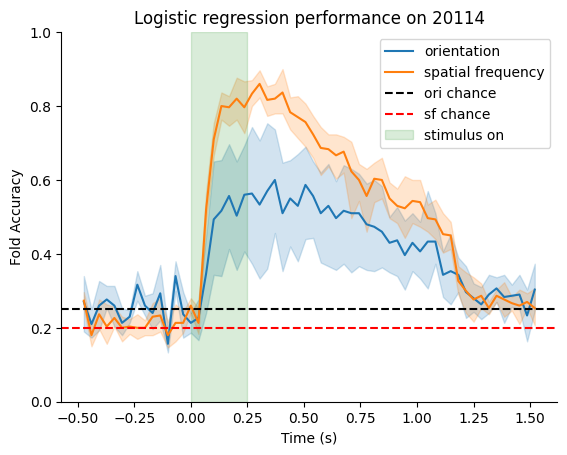

In [47]:
plt.figure()
plt.title("Logistic regression performance on {}".format(mouse_id))
sns.lineplot(data=results, x='time', y='acc', hue='modality')
plt.axhline(1/len(all_orientations), color='k', ls='--', label='ori chance')
plt.axhline(1/len(all_sfs), color='r', ls='--', label='sf chance')
plt.axvspan(0, 0.25, color='green', alpha=0.15, label='stimulus on')
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Fold Accuracy")
sns.despine()
plt.ylim([0, 1])

In [21]:
x_axis[30]

0.5405709780956135

## Hyperparameter search, to find a good value for the regularization factor

In [48]:
# Parameters for GridSearchCV
param_grid = {
    'C':np.round(np.logspace(-4, 4, 30), 5),  # Regularization strengths on a logarithmic scale
    'solver': ['lbfgs'],  # Could add more solvers like 'saga' that supports l1 penalty
}

model = LogisticRegression(multi_class='multinomial', max_iter=1000)
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
results = pd.DataFrame()

# Iterate over each timepoint
#for t in range(X_flat.shape[-1]):
for t in tqdm(range(12, 40)):
    X_t = X_flat[:, :, t]
    grid_search.fit(X_t, Y_or_flat)
    #grid_search.fit(X_t, Y_sf_flat)
    
    # Collecting results
    cv_results = pd.DataFrame(grid_search.cv_results_)
    cv_results['timepoint'] = np.round(x_axis[t], 2)
    results = pd.concat([results, cv_results], ignore_index=True)

100%|██████████| 28/28 [00:36<00:00,  1.31s/it]


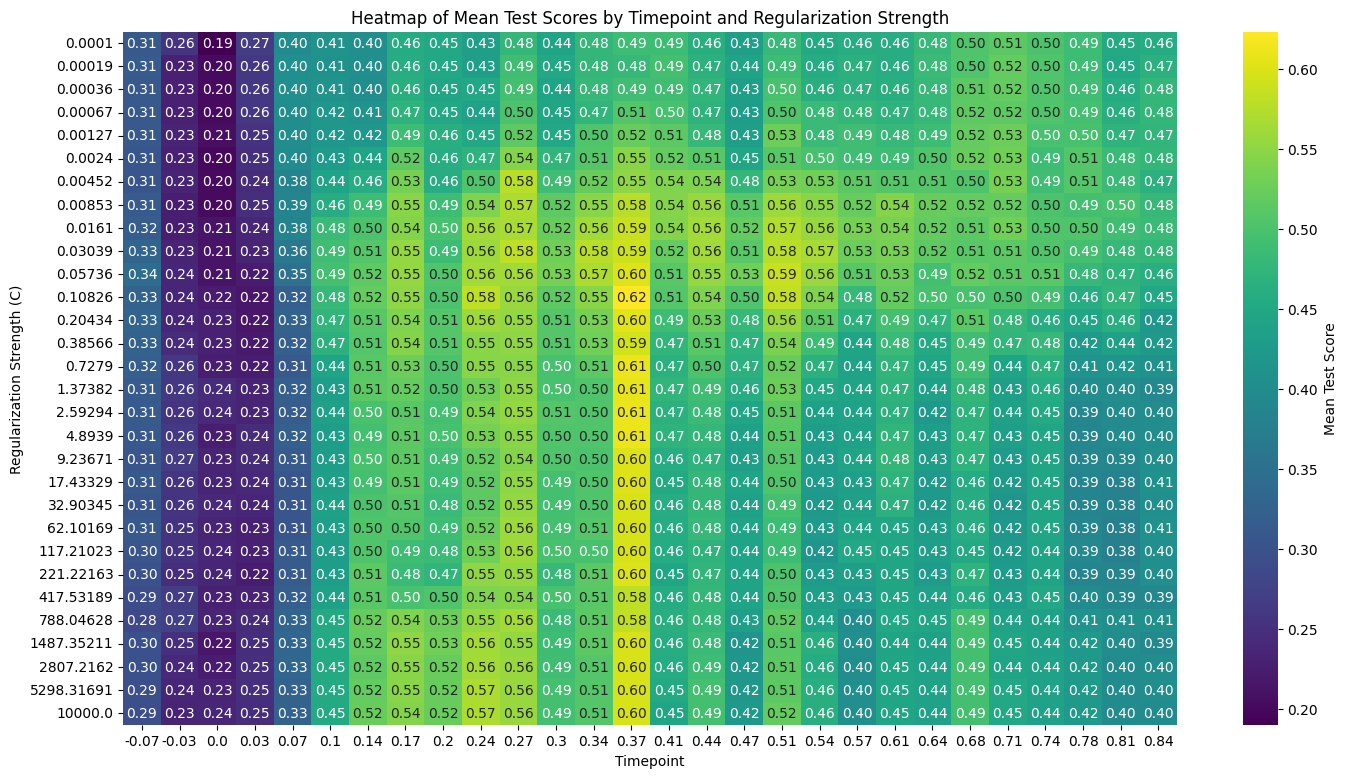

In [49]:
# Pivot the DataFrame to create a matrix suitable for the heatmap
result_pivot = results.pivot(index='param_C', columns='timepoint', values='mean_test_score')

# Plotting the heatmap
plt.figure(figsize=(17, 9))
sns.heatmap(result_pivot, annot=True, fmt=".2f", cmap="viridis", cbar_kws={'label': 'Mean Test Score'})

plt.title("Heatmap of Mean Test Scores by Timepoint and Regularization Strength")
plt.xlabel("Timepoint")
plt.ylabel("Regularization Strength (C)")
plt.yticks(rotation=0)  # Keep the y labels horizontal
plt.show()

In [25]:
np.logspace(-5, 5, 11)

array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03, 1.e+04, 1.e+05])